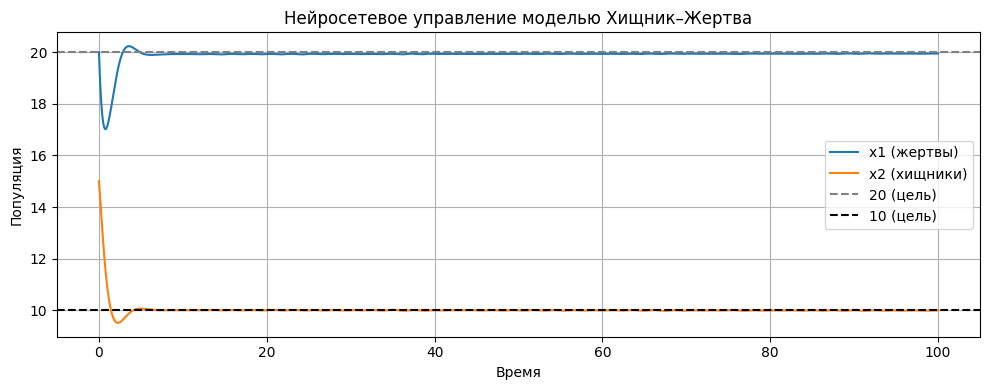

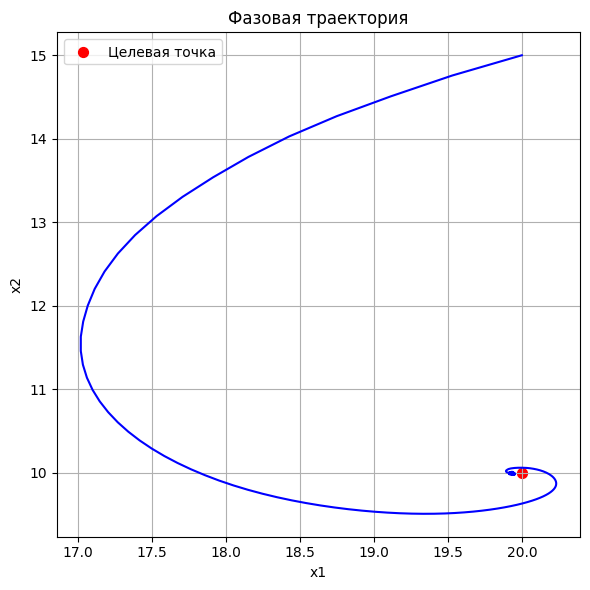

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Параметры модели
a, b, c, d = 1.0, 0.1, 1.5, 0.075
x_star = np.array([20.0, 10.0])   # цели

# Простейшая однослойная нейросеть
class SimpleNN:
    def __init__(self):
        # Очень маленькие случайные веса
        self.W = np.random.randn(2, 2) * 1e-4
        self.b = np.zeros(2)
    def predict(self, e):
        return self.W @ e + self.b
    def train(self, e, u, lr=0.001):
        # Подгоняем веса так, чтобы сеть приближалась к истинному u
        self.W += lr * np.outer(u, e)
        self.b += lr * u
        # Ограничиваем рост весов
        self.W = np.clip(self.W, -50, 50)
        self.b = np.clip(self.b, -50, 50)

nn = SimpleNN()
use_control = True
u_hist = []

# Пропорциональный коэффициент для «PD»-компоненты
Kp = np.array([1.0, 1.0])

def model(t, state):
    x1, x2 = state
    x = np.array([x1, x2])
    e = x - x_star

    if use_control:
        # Составной контрол: нейросеть + простейший P-контроллер
        u_nn = -nn.predict(e)
        u_p  = -Kp * e
        u = u_nn + u_p
        u = np.clip(u, -100, 100)
        nn.train(e, u, lr=0.001)
    else:
        u = np.zeros(2)

    u_hist.append(u.copy())

    dx1 = x1 * (a - b * x2) + u[0]
    dx2 = -x2 * (c - d * x1) + u[1]
    dx1 = max(dx1, -x1)
    dx2 = max(dx2, -x2)
    return [dx1, dx2]

# Начальные условия поближе к цели
x0 = [20.0, 15.0]
t_span = [0, 100]
t_eval = np.linspace(*t_span, 2000)

sol = solve_ivp(model, t_span, x0, t_eval=t_eval, method='RK45')
t = sol.t
x1, x2 = sol.y
u_arr = np.array(u_hist)

# График популяций
plt.figure(figsize=(10,4))
plt.plot(t, x1, label='x1 (жертвы)')
plt.plot(t, x2, label='x2 (хищники)')
plt.axhline(x_star[0], linestyle='--', color='gray',  label='20 (цель)')
plt.axhline(x_star[1], linestyle='--', color='black', label='10 (цель)')
plt.title("Нейросетевое управление моделью Хищник–Жертва")
plt.xlabel("Время")
plt.ylabel("Популяция")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Фазовая траектория
plt.figure(figsize=(6,6))
plt.plot(x1, x2, color='blue')
plt.scatter(*x_star, color='red', s=50, label='Целевая точка')
plt.title("Фазовая траектория")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

